In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from collections import deque

from tqdm import tqdm

# plt.rcParams['animation.writer'] = 'ffmpeg'
import imageio

In [33]:
class box_with_particles:
    def __init__(self, dt = 0.1, t_stop = 2.5, box_length = [1,1], number_of_particles = 1, particle_radius = 0.05) -> None:

        self.dt = dt
        self.t_stop = t_stop
        self.time_list = np.arange(0, t_stop, dt)
        self.number_of_time_steps = len(self.time_list)
        self.box_length = box_length
        self.box_length_x = box_length[0]
        self.box_length_y = box_length[1]
        self.number_of_particles = number_of_particles
        self.particle_radius = particle_radius
        self.hitting_distance = 2*particle_radius

        self.x_list = np.zeros( ( len(self.time_list), self.number_of_particles ))
        self.y_list = np.zeros( ( len(self.time_list), self.number_of_particles ))

        self.vx_list = np.zeros( ( len(self.time_list), self.number_of_particles ))
        self.vy_list = np.zeros( ( len(self.time_list), self.number_of_particles ))

        self.current_it = 0

        self.hitting_particles_list = []

        self.color_list = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

        return

    def set_initial_positions(self, initial_positions_x, initial_positions_y):
        for i in range(self.number_of_particles):
            self.x_list[0, i] = initial_positions_x[i]
            self.y_list[0, i] = initial_positions_y[i]
        return

    def set_initial_positions_random(self):
        frame = 0.05
        for i in range(self.number_of_particles):
            x = np.random.rand() * self.box_length_x*(1-2*frame) + self.box_length_x*frame
            y = np.random.rand() * self.box_length_y*(1-2*frame) + self.box_length_y*frame
            self.x_list[0, i] = x
            self.y_list[0, i] = y
        return
    
    def set_initial_velocities(self, initial_velocities_x, initial_velocities_y):
        for i in range(self.number_of_particles):
            self.vx_list[0, i] = initial_velocities_x[i]
            self.vy_list[0, i] = initial_velocities_y[i]
        return
    
    def set_initial_velocities_random(self):
        for i in range(self.number_of_particles):
            v_theta = np.random.rand() * 2*np.pi
            vx = np.cos(v_theta)
            vy = np.sin(v_theta)
            self.vx_list[0, i] = vx
            self.vy_list[0, i] = vy
        return
    
    def prepare_simulation_random(self):
        self.set_initial_positions_random()
        self.set_initial_velocities_random()
        return

    def make_time_step(self):
        self.current_it += 1
        it = self.current_it
        for i in range(self.number_of_particles):
            vx = self.vx_list[it-1, i]
            vy = self.vy_list[it-1, i]
            self.x_list[it, i] = self.x_list[it-1, i] + vx*self.dt
            self.y_list[it, i] = self.y_list[it-1, i] + vy*self.dt

            # Update velocities
            self.update_velocities(vx, vy, it, i)

        return
    
    def update_velocities(self, vx, vy, it, i):
        self.vx_list[it, i] = vx
        self.vy_list[it, i] = vy

        # CHECKING IF THE PARTICLE IS GETTING OUTSIDE THE BOX
        # For x-axis
        if self.x_list[it, i] < 0 or self.x_list[it, i] > self.box_length_x:
            self.vx_list[it, i] *= -1.0
        # For y-axis
        if self.y_list[it, i] < 0 or self.y_list[it, i] > self.box_length_y:
            self.vy_list[it, i] *= -1.0

        # CHECKING IF THE PARTICLE IS HITTING ANOTHER PARTICLE
        for i2 in range(self.number_of_particles):
            if i2 != i and i2 not in self.hitting_particles_list:
                dx = self.x_list[it, i2] - self.x_list[it, i]
                dy = self.y_list[it, i2] - self.y_list[it, i]
                distance = np.sqrt(dx*dx + dy*dy)
                if distance < self.hitting_distance:
                    # exchange velocities
                    vx_buffer = self.vx_list[it, i].copy()
                    vy_buffer = self.vy_list[it, i].copy()
                    self.vx_list[it, i] = self.vx_list[it, i2].copy()
                    self.vy_list[it, i] = self.vy_list[it, i2].copy()
                    self.vx_list[it, i2] = vx_buffer.copy()
                    self.vy_list[it, i2] = vy_buffer.copy()

                    if self.vx_list[it, i] == 0:
                        print('it',self.current_it)
                        print('i',i)
                    if self.vy_list[it, i] == 0:
                        print('it',self.current_it)
                        print('i',i)
                    if self.vx_list[it, i2] == 0:
                        print('it',self.current_it)
                        print('i2',i2)
                    if self.vy_list[it, i2] == 0:
                        print('it',self.current_it)
                        print('i2',i2)

                self.hitting_particles_list.append(i2)
            else:
                if i2 in self.hitting_particles_list:
                    self.hitting_particles_list.remove(i2)
        return

    def run_simulation(self):
        for step in tqdm( range(self.number_of_time_steps-1) ):
            self.make_time_step()
        return
    


    
    def prepare_figure(self):
        fig = plt.figure(figsize=(5, 4))

        ax = fig.add_subplot(autoscale_on=False, xlim=(0, self.box_length_x), ylim=(0, self.box_length_y))
        ax.set_aspect('equal')
        
        # fig, ax = plt.subplots()
        # ax.set_xlim([0, self.box_length_x])
        # ax.set_ylim([0, self.box_length_y])

        self.fig = fig
        self.ax = ax
        ax.grid()

        lines = []
        for i in range( self.number_of_particles ):
            line, = self.ax.plot([], [], 'o', color=self.color_list[i], lw=2)
            lines.append(line)
            
        time_template = 'time = %.1fs'
        time_text = self.ax.text(0.05, 0.9, '', transform=ax.transAxes)
        
        self.lines = lines.copy()
        self.time_template = time_template
        self.time_text = time_text
        return
    
    def animate(self, this_it):
        this_x = []
        this_y = []
        lines = self.lines.copy()
        for i, line in enumerate( lines ):
            this_x.append( self.x_list[this_it, i] )
            this_y.append( self.y_list[this_it, i] )
            
            line.set_data(self.x_list[this_it, i], self.y_list[this_it, i])

        self.time_text.set_text(self.time_template % (this_it*self.dt))
        
        return lines, self.time_text
    
    def create_animation(self):
        self.prepare_figure()

        ani = animation.FuncAnimation(
            self.fig, self.animate, self.number_of_time_steps, interval=self.dt*1000, blit=True)

        writer = PillowWriter(fps=24)
        ani.save('animation.gif', writer='imagemagick')  # Save as GIF
        plt.show()

In [35]:
print('Running simulation')
simulation = box_with_particles(dt = 0.05, t_stop = 20, box_length = [3,2], number_of_particles = 10, particle_radius=0.1)
simulation.prepare_simulation_random()
simulation.run_simulation()

Running simulation


100%|██████████| 399/399 [00:00<00:00, 4090.16it/s]

it 166
i 3
it 166
i 3
it 166
i 3
it 166
i 3
it 166
i2 6
it 166
i2 6
it 166
i 3
it 166
i 3
it 166
i2 8
it 166
i2 8
it 167
i 3
it 167
i 3
it 167
i2 4
it 167
i2 4
it 167
i 3
it 167
i 3
it 167
i2 6
it 167
i2 6
it 167
i 3
it 167
i 3
it 167
i2 8
it 167
i2 8
it 168
i 3
it 168
i 3
it 168
i2 4
it 168
i2 4
it 168
i 3
it 168
i 3
it 168
i2 6
it 168
i2 6
it 168
i 3
it 168
i 3
it 168
i2 8
it 168
i2 8
it 169
i 3
it 169
i 3
it 169
i2 4
it 169
i2 4
it 169
i 3
it 169
i 3
it 169
i2 6
it 169
i2 6
it 169
i 3
it 169
i 3
it 169
i2 8
it 169
i2 8
it 170
i 3
it 170
i 3
it 170
i2 4
it 170
i2 4
it 170
i 3
it 170
i 3
it 170
i2 6
it 170
i2 6
it 170
i 3
it 170
i 3
it 170
i2 8
it 170
i2 8
it 171
i 3
it 171
i 3
it 171
i2 4
it 171
i2 4
it 171
i 3
it 171
i 3
it 171
i2 6
it 171
i2 6
it 171
i 3
it 171
i 3
it 171
i2 8
it 171
i2 8
it 172
i 3
it 172
i 3
it 172
i2 4
it 172
i2 4
it 172
i 3
it 172
i 3
it 172
i2 6
it 172
i2 6
it 172
i 3
it 172
i 3
it 172
i2 8
it 172
i2 8
it 173
i 3
it 173
i 3
it 173
i2 4
it 173
i2 4
it 173
i 3
i


Creating animation
number of time steps = 400


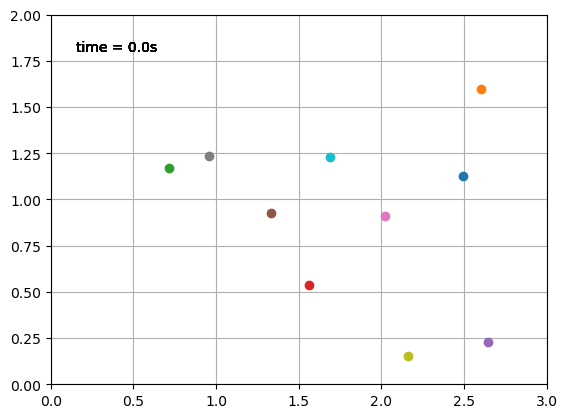

In [36]:
print('\nCreating animation')
print('number of time steps = %.0f' % (simulation.number_of_time_steps))
# simulation.create_animation()

# Create the figure and axes
fig, ax = plt.subplots()
ax.set_xlim(0, simulation.box_length_x)
ax.set_ylim(0, simulation.box_length_y)

# Initialize the lines to be plotted
lines = []
time_texts = []

# Create and append line objects to the lines list
for i in range(simulation.number_of_particles):
    line, = ax.plot([], [], 'o', color=simulation.color_list[i])
    lines.append(line)

    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    time_texts.append(time_text)

time_template = 'time = %.1fs'

# Define the update function for the animation
def update(frame):    
    # Update the data for each line
    
    for i, line in enumerate(lines):
        line.set_data(simulation.x_list[frame, i], simulation.y_list[frame, i])

    for i, time_text in enumerate(time_texts):
        time_text.set_text(time_template % (frame*simulation.dt))
    
    return lines

# Create the animation
my_animation = animation.FuncAnimation(fig, update, frames=simulation.number_of_time_steps, interval=50, blit=True)

# Display the plot
plt.grid()
plt.show()

writer = PillowWriter(fps=24)
my_animation.save('animation.gif', writer=writer)  # Save as GIF


In [27]:
simulation.number_of_particles

10

In [30]:
len(simulation.y_list[0,:])

10